### Full Tutorial on Calibrating Denoisers Using J-Invariance
[link to example](https://scikit-image.org/docs/stable/auto_examples/filters/plot_phase_unwrap.html#sphx-glr-auto-examples-filters-plot-phase-unwrap-py)

In this example, we show how to find an optimally calibrated version of any denoising algorithm.

The calibration method is based on the `noise2self` algorithm.

Calibrating a wave denoiser:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


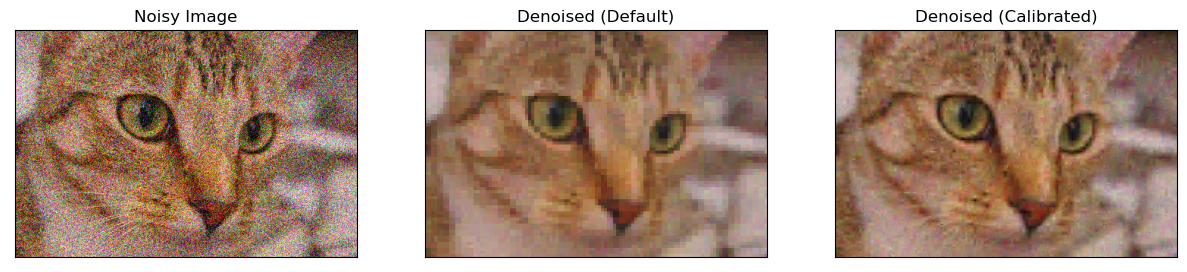

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec

from skimage.data import chelsea, hubble_deep_field
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import (
    calibrate_denoiser, denoise_wavelet, denoise_tv_chambolle,
    denoise_nl_means, estimate_sigma
)
from skimage.util import img_as_float, random_noise
from skimage.color import rgb2gray
from functools import partial

_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)

image = img_as_float(chelsea())
sigma = 0.2
noisy = random_noise(image, var=sigma ** 2)

# Parameters to test when calibrating the denoising algorithm
parameter_ranges = {
    'sigma': np.arange(0.1, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    'convert2ycbcr': [True, False],
    'channel_axis': [-1]
}

# Denoised image using default parameters of 'denoise_wavelet'
default_output = denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True)

# Calibrate denoiser
calibrated_denoiser = calibrate_denoiser(noisy, _denoise_wavelet, denoise_parameters=parameter_ranges)

# Denoised image using calibrated denoiser
calibrated_output = calibrated_denoiser(noisy)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for ax, img, title in zip(axes,
                          [noisy, default_output, calibrated_output],
                          ['Noisy Image', 'Denoised (Default)', 'Denoised (Calibrated)']):

    ax.imshow(img)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

#### The Self-Supervised Loss and J-Invariance
The key to this calibration method is the notion of J-invariance. A denoising function is J-invariant if the prediction it makes for each pixel does not depend on the value of that pixel in the original image. The prediction for each pixel may instead use all the relevant information contained in the rest of the image. The prediction for each pixel may instead use all the relevant information contained in the rest of the image, which is typically quitesignificant. Any function can be converted into a J-invariant one using a simple masking procedure.

The pixel-wise error of a J-invariant denoiser is uncorrelated to the noise, so long as the noise in each pixel is independent. Consequently, the average difference between the denoised image and the noisy image, the *self-supervised loss*, is the same as the difference between the denoised image and the original clean image, the *ground-truth loss* (up to a constant).

This means that the best J-invariant denoiser for a given image can be found using the noisy data alone, by selecting the denoiser minimizing the self-supervised loss. Below, we demonstrate this for a family of a wavelet denoisers with varying *sigma* parameter. The self-supervised loss (solid blue line) and the ground-truth loss (dashed blue line) have the same shape and the same minimizer.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ssl:  [0.04355845161873347, 0.04245477811600855, 0.04046843016915164, 0.03835840740247573, 0.03806354841348061, 0.03809320298333408, 0.03813813761167538, 0.03826314779370661, 0.03845231566907693]
gtl:  [0.007504088178942267, 0.0064429337174446355, 0.004507882957513663, 0.002440448710695246, 0.0021986568045474406, 0.0022441741753365437, 0.0023079158366075426, 0.0024498321330821892, 0.0026655213050271413]


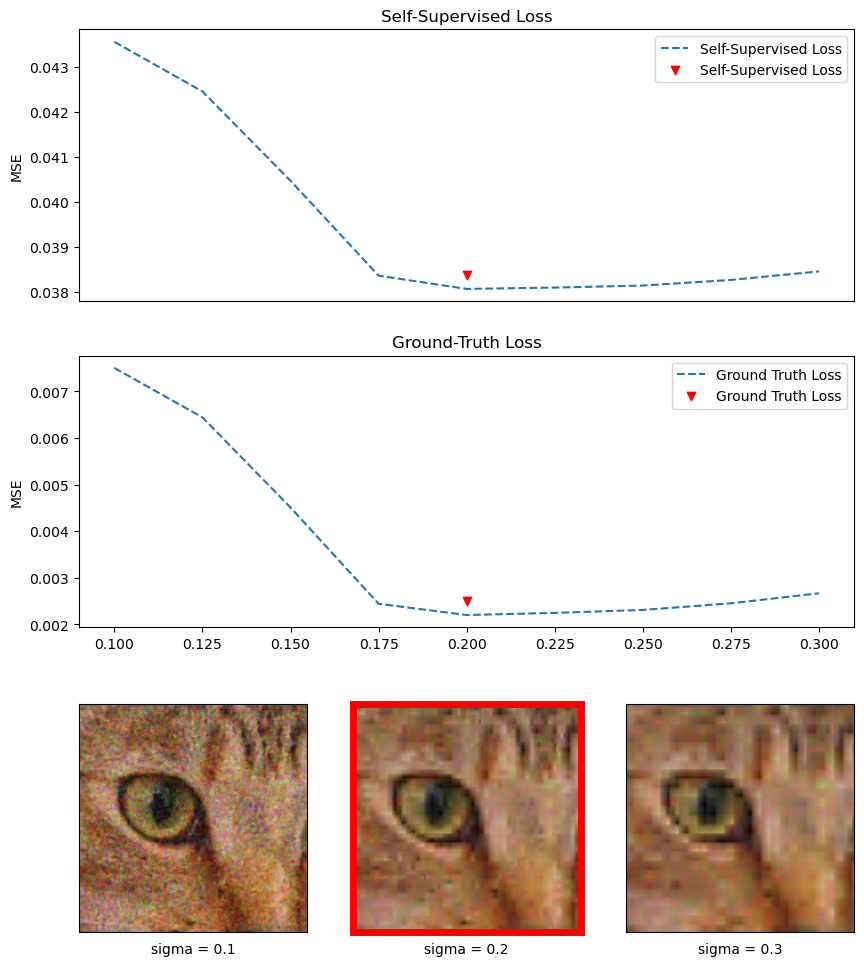

In [33]:
from skimage.restoration.j_invariant import _invariant_denoise

sigma_range = np.arange(sigma/2, 1.5*sigma, 0.025)

parameters_tested = [{'sigma': sigma, 'convert2ycbcr': True, 'wavelet': 'db2', 'channel_axis': -1}
                     for sigma in sigma_range]

denoised_invariant = [_invariant_denoise(noisy, _denoise_wavelet, denoiser_kwargs=params)
                      for params in parameters_tested]

self_supervised_loss = [mse(img, noisy) for img in denoised_invariant]
ground_truth_loss = [mse(img, image) for img in denoised_invariant]

print("ssl: ", self_supervised_loss)
print("gtl: ", ground_truth_loss)

opt_idx = np.argmin(self_supervised_loss)
plot_idx = [0, opt_idx, len(sigma_range) -1]

get_inset = lambda x: x[25:225, 100:300]

plt.figure(figsize=(10, 12))

gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax_image = [plt.subplot(gs[2, i]) for i in range(3)]

ax1.plot(sigma_range, self_supervised_loss, color='C0', linestyle="--", label="Self-Supervised Loss")
ax1.scatter(
    sigma_range[opt_idx], self_supervised_loss[opt_idx] + 0.0003, marker='v', color="red", label="Self-Supervised Loss"
)

ax1.set_ylabel('MSE')
ax1.set_xticks([])
ax1.legend()
ax1.set_title("Self-Supervised Loss")

ax2.plot(sigma_range, ground_truth_loss, color='C0', linestyle='--', label="Ground Truth Loss")
ax2.scatter(
    sigma_range[opt_idx], ground_truth_loss[opt_idx] + 0.0003, marker='v', color="red", label="Ground Truth Loss"
)
ax2.set_ylabel('MSE')
ax2.legend()
ax2.set_title("Ground-Truth Loss")

for i in range(3):
    ax = ax_image[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(get_inset(denoised_invariant[plot_idx[i]]))
    ax.set_xlabel('sigma = ' + str(np.round(sigma_range[plot_idx[i]], 2)))

for spine in ax_image[1].spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(5)

#### Conversion to J-invariance
The function *_invariant_denoise* acts as a J-invariant version of a given denoiser. It works by masking a fraction of the pixels, interpolating them, running the original denoiser, and extracting the values returned in the masked pixels. Iterating over the image results in a faulty J-invariant output.

For any given set of parameters, the J-invariant version of denoiser is different from the original denoiser, but it is not necessarily better or worse. In the plot below, we see that, for the test image of a cat, the J-invariant version of a wavelet denoiser is significantly better than the original at small values of variance-reduction *sigma* and imperceptibly worse at larger values.

Text(0.5, 0, 'sigma')

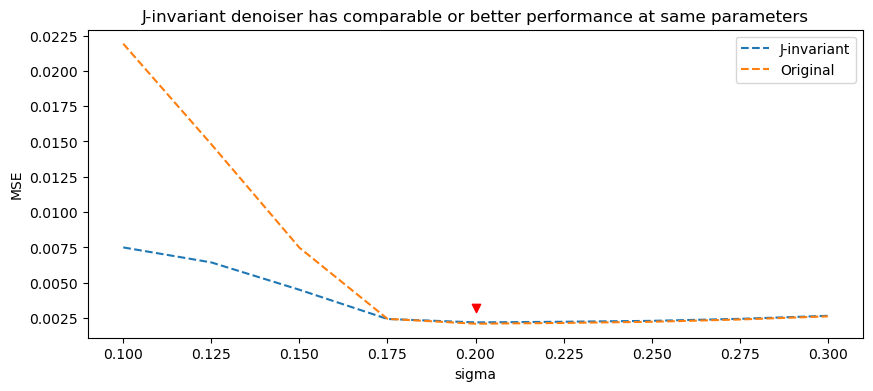

In [36]:
parameters_tested = [
    {'sigma': sigma, 'convert2ycbcr': True, 'wavelet': 'db2', 'channel_axis': -1}
    for sigma in sigma_range
]

denoised_original = [_denoise_wavelet(noisy, **params) for params in parameters_tested]

ground_truth_loss_invariant = [mse(img, image) for img in denoised_invariant]
ground_truth_loss_original = [mse(img, image) for img in denoised_original]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(sigma_range, ground_truth_loss_invariant, color='C0', linestyle='--', label='J-invariant')
ax.plot(sigma_range, ground_truth_loss_original, color='C1', linestyle='--', label='Original')
ax.scatter(sigma_range[opt_idx], ground_truth_loss[opt_idx] + 0.001, marker='v', color='red')
ax.legend()
ax.set_title(
    'J-invariant denoiser has comparable or '
    'better performance at same parameters'
)
ax.set_ylabel('MSE')
ax.set_xlabel('sigma')

#### Comparing Different Classes of Denoiser
The self-supervised loss can be used to compare different classes of denoiser in addition to choosing parameters of a single class. This allows the user to, in an unbiased way, choose the best parameters for the best class of denoiser for a given image.

Below, we show this for an image of the hubble deep field with significant speckle noise added. In this case, the J-invariant calibrated denoiser is better than the default denoiser in each of three families of denoisers - Non-local means, wavelet, and TV norm denoiser is the best for this noisy image.

Minimum self-supervised loss TV: 0.0042
Minimum self-supervised loss: 0.0042
Minimum self-supervised loss NL means: 0.0050
                           PSNR
NL means (Default)       : 25.7
NL means (Calibrated)    : 27.2
Wavelet (Default)        : 27.0
Wavelet (Calibrated)     : 27.0
TV norm (Default)        : 28.7
TV norm (Calibrated)     : 29.4


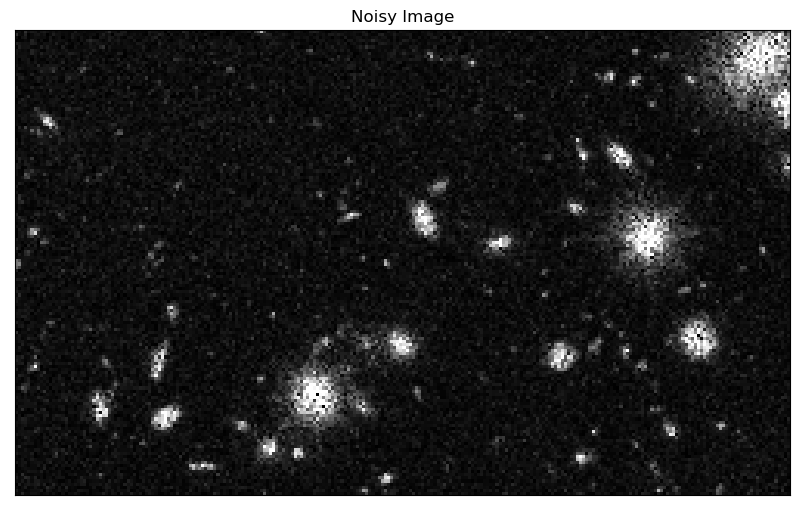

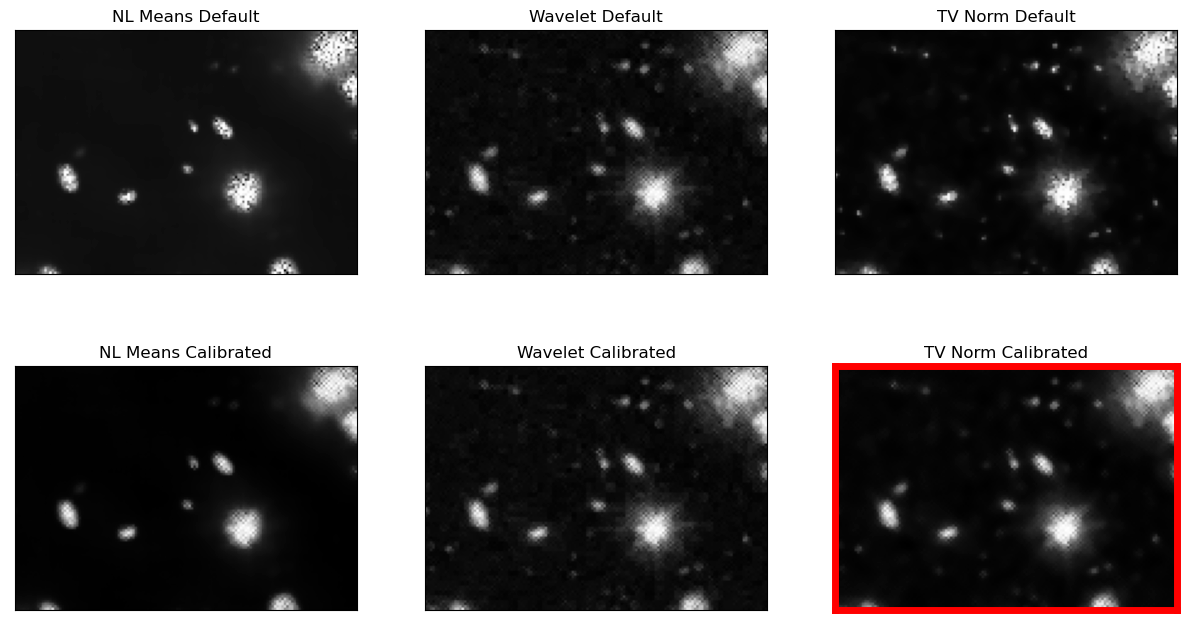

In [53]:
image = rgb2gray(img_as_float(hubble_deep_field()[100:250, 50:300]))

sigma = 0.4
noisy = random_noise(image, mode='speckle', var=sigma ** 2)

parameter_ranges_tv = {'weight': np.arange(0.01, 0.3, 0.02)}
_, (parameters_tested_tv, losses_tv) = calibrate_denoiser(
    noisy, denoise_tv_chambolle, 
    denoise_parameters=parameter_ranges_tv, extra_output=True
)

print(f"Minimum self-supervised loss TV: {np.min(losses_tv):.4f}")

best_parameters_tv = parameters_tested_tv[np.argmin(losses_tv)]
denoised_calibrated_tv = _invariant_denoise(noisy, denoise_tv_chambolle, denoiser_kwargs=best_parameters_tv)
denoised_default_tv = denoise_tv_chambolle(noisy, **best_parameters_tv)

psnr_calibrated_tv = psnr(image, denoised_calibrated_tv)
psnr_default_tv = psnr(image, denoised_default_tv)

parameter_ranges_wavelet = {'sigma': np.arange(0.01, 0.3, 0.03)}
_, (parameters_tested_wavelet, losses_wavelet) = calibrate_denoiser(
    noisy, _denoise_wavelet, parameter_ranges_wavelet, extra_output=True
)
print(f'Minimum self-supervised loss: {np.min(losses_wavelet):.4f}')

best_parameters_wavelet = parameters_tested_wavelet[np.argmin(losses_wavelet)]
denoised_calibrated_wavelet = _invariant_denoise(
    noisy, _denoise_wavelet,
    denoiser_kwargs=best_parameters_wavelet
)
denoised_default_wavelet = _denoise_wavelet(noisy, **best_parameters_wavelet)

psnr_calibrated_wavelet = psnr(image, denoised_calibrated_wavelet)
psnr_default_wavelet = psnr(image, denoised_default_wavelet)

sigma_est = estimate_sigma(noisy)

# why is this in this tutorial?
#parameters_ranges_nl = {'sigma': np.arange(0.6, 1.4, 0.2) * sigma_est, 'h': np.arange(0.6, 1.2, 0.2) * sigma_est}
parameters_ranges_nl = {'sigma': np.arange(0.01, 0.3, 0.03)}

_, (parameters_tested_nl, losses_nl) = calibrate_denoiser(
    noisy, denoise_nl_means, parameter_ranges_nl, extra_output=True
)
print(f'Minimum self-supervised loss NL means: {np.min(losses_nl):.4f}')

best_parametetres_nl = parameters_tested_nl[np.argmin(losses_nl)]
denoised_calibrated_nl = _invariant_denoise(noisy, denoise_nl_means, denoiser_kwargs=best_parameters_nl)

denoised_default_nl = denoise_nl_means(noisy, **best_parameters_nl)

psnr_calibrated_nl = psnr(image, denoised_calibrated_nl)
psnr_default_nl = psnr(image, denoised_default_nl)

print(f'                           PSNR')
print(f'NL means (Default)       : {psnr_default_nl:.1f}')
print(f'NL means (Calibrated)    : {psnr_calibrated_nl:.1f}')
print(f'Wavelet (Default)        : {psnr_default_wavelet:.1f}')
print(f'Wavelet (Calibrated)     : {psnr_default_wavelet:.1f}')
print(f'TV norm (Default)        : {psnr_default_tv:.1f}')
print(f'TV norm (Calibrated)     : {psnr_calibrated_tv:.1f}')

plt.subplots(figsize=(10, 12))
plt.imshow(noisy, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.title('Noisy Image')

get_inset = lambda x: x[0:100, -140:]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,8))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].imshow(get_inset(denoised_default_nl), cmap='Greys_r')
axes[0, 0].set_title('NL Means Default')
axes[1, 0].imshow(get_inset(denoised_calibrated_nl), cmap='Greys_r')
axes[1, 0].set_title('NL Means Calibrated')
axes[0, 1].imshow(get_inset(denoised_calibrated_wavelet), cmap='Greys_r')
axes[0, 1].set_title('Wavelet Default')
axes[1, 1].imshow(get_inset(denoised_calibrated_wavelet), cmap='Greys_r')
axes[1, 1].set_title('Wavelet Calibrated')
axes[0, 2].imshow(get_inset(denoised_default_tv), cmap='Greys_r')
axes[0, 2].set_title('TV Norm Default')
axes[1, 2].imshow(get_inset(denoised_calibrated_tv), cmap='Greys_r')
axes[1, 2].set_title('TV Norm Calibrated')

for spine in axes[1, 2].spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(5)

plt.show()